<h1> Flip data during training </h1>

The idea comes from Johannes Rieke and his [article](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) about object detection.

**Current problem:** Labeling the data as photon 1 and photon 2 limits the network in learning. 

**Idea:** Flip data in a way so that MSE is the lowest.

[This](https://github.com/jrieke/shape-detection/blob/master/two-rectangles.ipynb) is the GitHub code. 

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

In [2]:
rootfile = uproot.open('./stage4_clusters.root')
ipd = hf.InputData_2photon(rootfile, sort_cond='none')
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  100.55668663978577 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [3]:
model = keras.Sequential([layers.Input(shape=(81)),
                         layers.Normalization(mean=2.5, variance=13.4),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(512, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(6, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 81)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               10496     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8

**Before:** ```fit_hist = model.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=50, validation_split=0.1)```

**Now:**

In [4]:
num_epochs = 200 # number of epochs
train_y = ipd.training # trainings
flipped = np.zeros((len(train_y), num_epochs)) # save info if one clipped the data or not
loss = []
val_loss = []


a = time.time()
for epoch in range(num_epochs): # perform one epoch, then adjust and so on
    print('Epoch', epoch)
    
    fit_hist = model.fit(ipd.clusters_t, train_y, epochs=1, validation_split=0.1, verbose=2)
    loss.append(fit_hist.history['loss'])
    val_loss.append(fit_hist.history['val_loss'])
    
    pred_y = model.predict(ipd.clusters_t)
    pred_y_flipped = np.roll(pred_y, 3, axis=1)
    
    mse = np.mean(np.square(pred_y-train_y), axis=1)
    mse_flipped = np.mean(np.square(pred_y_flipped-train_y), axis=1)
    
    ind_flip = np.where(mse_flipped<mse)
    train_y[ind_flip] = np.roll(train_y[ind_flip], 3, axis=1)
    flipped[ind_flip, epoch] = 1 #indicate that data flipped

    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    
val_loss = np.array(val_loss).flatten()
loss = np.array(loss).flatten()



Epoch 0
9813/9813 - 11s - loss: 580.7923 - val_loss: 565.3754
Flipped 174539.0 training samples (50.0286633149697 %)
Epoch 1
9813/9813 - 11s - loss: 116.9089 - val_loss: 104.6152
Flipped 3646.0 training samples (1.045064463795367 %)
Epoch 2
9813/9813 - 11s - loss: 97.1009 - val_loss: 90.9028
Flipped 3262.0 training samples (0.9349973343117077 %)
Epoch 3
9813/9813 - 11s - loss: 89.3183 - val_loss: 89.9214
Flipped 3352.0 training samples (0.9607943177844405 %)
Epoch 4
9813/9813 - 11s - loss: 84.8284 - val_loss: 85.2725
Flipped 3304.0 training samples (0.9470359265989831 %)
Epoch 5
9813/9813 - 11s - loss: 81.6204 - val_loss: 82.8519
Flipped 3296.0 training samples (0.9447428614014067 %)
Epoch 6
9813/9813 - 11s - loss: 79.0180 - val_loss: 79.6252
Flipped 2843.0 training samples (0.8148980445886528 %)
Epoch 7
9813/9813 - 11s - loss: 76.9713 - val_loss: 80.5945
Flipped 3200.0 training samples (0.917226079030492 %)
Epoch 8
9813/9813 - 11s - loss: 75.2865 - val_loss: 78.4840
Flipped 3847.0 tra

9813/9813 - 11s - loss: 52.4103 - val_loss: 61.9140
Flipped 2315.0 training samples (0.6635557415486216 %)
Epoch 72
9813/9813 - 11s - loss: 52.0804 - val_loss: 61.6080
Flipped 2160.0 training samples (0.6191276033455821 %)
Epoch 73
9813/9813 - 11s - loss: 51.9174 - val_loss: 63.8618
Flipped 2123.0 training samples (0.6085221768067921 %)
Epoch 74
9813/9813 - 11s - loss: 51.9396 - val_loss: 62.2619
Flipped 2546.0 training samples (0.7297679991286352 %)
Epoch 75
9813/9813 - 11s - loss: 51.8624 - val_loss: 61.6623
Flipped 2390.0 training samples (0.6850532277758987 %)
Epoch 76
9813/9813 - 11s - loss: 51.6996 - val_loss: 62.0535
Flipped 2128.0 training samples (0.6099553425552773 %)
Epoch 77
9813/9813 - 11s - loss: 51.6773 - val_loss: 61.5052
Flipped 2696.0 training samples (0.7727629715831895 %)
Epoch 78
9813/9813 - 11s - loss: 51.5095 - val_loss: 61.6359
Flipped 2373.0 training samples (0.6801804642310493 %)
Epoch 79
9813/9813 - 11s - loss: 51.2346 - val_loss: 61.9700
Flipped 2242.0 train

Flipped 1849.0 training samples (0.5299846937898062 %)
Epoch 142
9813/9813 - 11s - loss: 45.6434 - val_loss: 61.3623
Flipped 1975.0 training samples (0.5661004706516318 %)
Epoch 143
9813/9813 - 11s - loss: 45.5888 - val_loss: 62.0362
Flipped 1905.0 training samples (0.5460361501728398 %)
Epoch 144
9813/9813 - 11s - loss: 45.3804 - val_loss: 61.7626
Flipped 2017.0 training samples (0.578139062938907 %)
Epoch 145
9813/9813 - 11s - loss: 45.5487 - val_loss: 61.2857
Flipped 2028.0 training samples (0.5812920275855744 %)
Epoch 146
9813/9813 - 11s - loss: 45.4410 - val_loss: 62.2597
Flipped 1954.0 training samples (0.5600811745079942 %)
Epoch 147
9813/9813 - 11s - loss: 45.2247 - val_loss: 62.1253
Flipped 1949.0 training samples (0.558648008759509 %)
Epoch 148
9813/9813 - 11s - loss: 45.3245 - val_loss: 60.6646
Flipped 1928.0 training samples (0.5526287126158715 %)
Epoch 149
9813/9813 - 11s - loss: 45.3468 - val_loss: 61.5290
Flipped 1842.0 training samples (0.527978261741927 %)
Epoch 150
98

11:08 Uhr bis 11:58Uhr

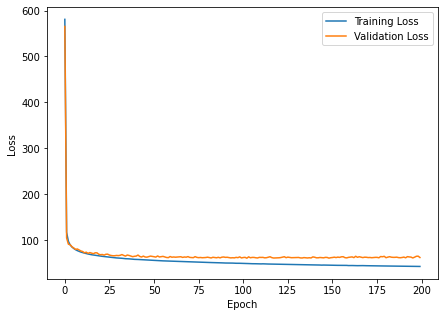

In [5]:
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"])

In [6]:
output = model.predict(ipd.clusters_v)
output_flipped = np.roll(output, 3, axis=1)

In [7]:
mse = np.mean(np.square(output-ipd.veri_truth), axis=1)
mse_flipped = np.mean(np.square(output_flipped-ipd.veri_truth), axis=1)

ind_flip = np.where(mse_flipped<mse)
output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)

In [8]:
ev = hf.Evaluation_2photon(ipd, output)

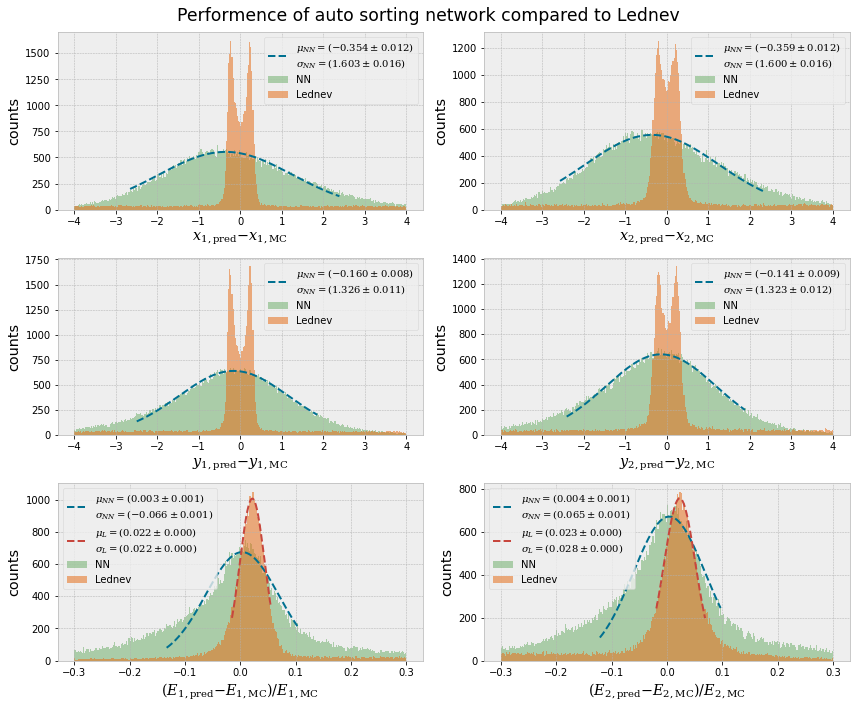

In [9]:
ev_fit_v_Lednev = ev.show_hist_NN_withLednev(figsave=(False, "auto sorting network"))

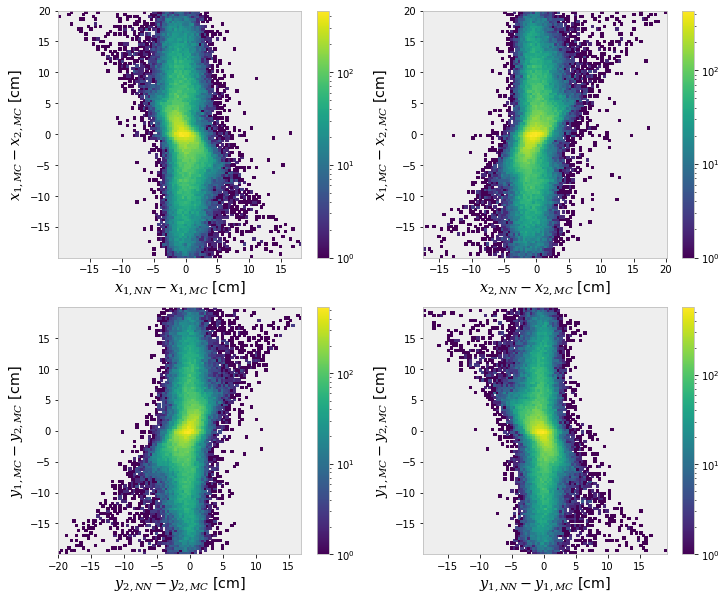

In [10]:
plt.subplot(2,2, 1)
abw_x = ev.x1 - ev.x1_t
diff_x = ev.x1_t-ev.x2_t
hist = plt.hist2d(abw_x, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(2,2, 2)
abw_x = ev.x2 - ev.x2_t
diff_x = ev.x1_t-ev.x2_t
hist = plt.hist2d(abw_x, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(2,2, 3)
abw_x = ev.y2 - ev.y2_t
diff_x = ev.y1_t-ev.y2_t
hist = plt.hist2d(abw_x, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(2,2, 4)
abw_x = ev.y1 - ev.y1_t
diff_x = ev.y1_t-ev.y2_t
hist = plt.hist2d(abw_x, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

In [11]:
keras.models.save_model(model, 'stage4model_auto_flip')

INFO:tensorflow:Assets written to: stage4model_auto_flip/assets


<h2> Many 2D plots (all combinations) </h2>


Zuerst alle $NN - MC$ vs. $\Delta MC$ (8 plots).

Dann  $NN - MC$ vs  $NN - MC$ (6 plots) und noch  $\Delta MC$ vs $\Delta MC$ (1 plot).

Also $\newline$
x x x x $\newline$
x x x x $\newline$
x x x x $\newline$
x x x

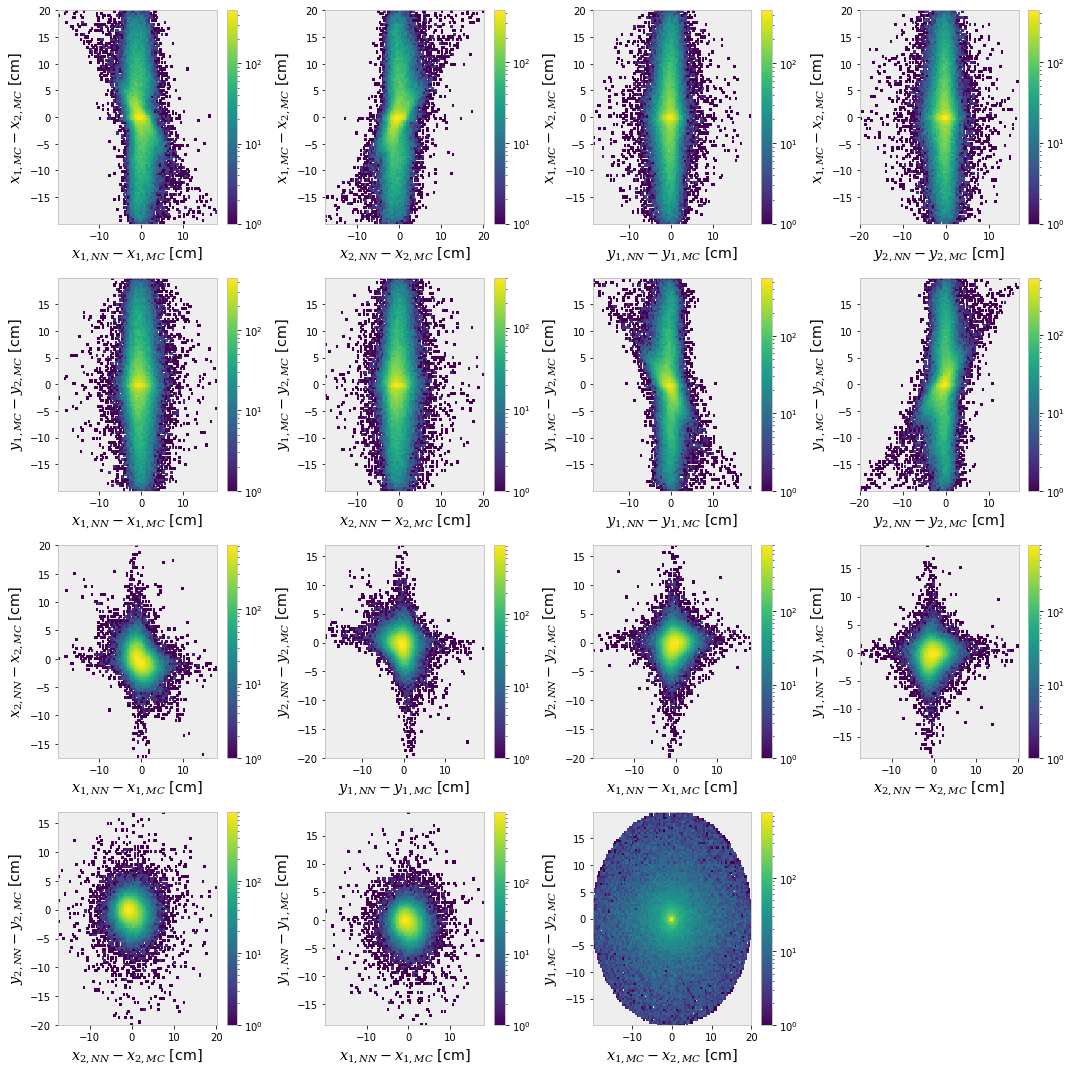

In [50]:
plt.rcParams["figure.figsize"] = (15,15)

diff_x = ev.x1_t-ev.x2_t
diff_y = ev.y1_t-ev.y2_t

# ersten 4: gegen x1_t - x2_t
plt.subplot(4,4, 1)
hist = plt.hist2d(ev.x1 - ev.x1_t, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 2)
hist = plt.hist2d(ev.x2 - ev.x2_t, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 3)
hist = plt.hist2d(ev.y1 - ev.y1_t, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 4)
hist = plt.hist2d(ev.y2 - ev.y2_t, diff_x, norm=LogNorm(), bins=100)
plt.xlabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.ylabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.colorbar()

# zweiten 4: gegen y1_t - y2_t
plt.subplot(4,4, 5)
hist = plt.hist2d(ev.x1 - ev.x1_t, diff_y, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 6)
hist = plt.hist2d(ev.x2 - ev.x2_t, diff_y, norm=LogNorm(), bins=100)
plt.xlabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 7)
hist = plt.hist2d(ev.y1 - ev.y1_t, diff_y, norm=LogNorm(), bins=100)
plt.xlabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 8)
hist = plt.hist2d(ev.y2 - ev.y2_t, diff_y, norm=LogNorm(), bins=100)
plt.xlabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

# dritten 4 +2: nicht gegen truth
plt.subplot(4,4, 9)
hist = plt.hist2d(ev.x1 - ev.x1_t, ev.x2 - ev.x2_t, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 10)
hist = plt.hist2d(ev.y1 - ev.y1_t, ev.y2 - ev.y2_t, norm=LogNorm(), bins=100)
plt.xlabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.ylabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 11)
hist = plt.hist2d(ev.x1 - ev.x1_t, ev.y2 - ev.y2_t, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 12)
hist = plt.hist2d(ev.x2 - ev.x2_t, ev.y1 - ev.y1_t, norm=LogNorm(), bins=100)
plt.xlabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.ylabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 13)
hist = plt.hist2d(ev.x2 - ev.x2_t, ev.y2 - ev.y2_t, norm=LogNorm(), bins=100)
plt.xlabel("$x_{2, NN} - x_{2, MC}$ [cm]")
plt.ylabel("$y_{2, NN} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.subplot(4,4, 14)
hist = plt.hist2d(ev.x1 - ev.x1_t, ev.y1 - ev.y1_t, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, NN} - x_{1, MC}$ [cm]")
plt.ylabel("$y_{1, NN} - y_{1, MC}$ [cm]")
plt.colorbar()

# zuletzt truth gegen turth

plt.subplot(4,4, 15)
hist = plt.hist2d(diff_x, diff_y, norm=LogNorm(), bins=100)
plt.xlabel("$x_{1, MC} - x_{2, MC}$ [cm]")
plt.ylabel("$y_{1, MC} - y_{2, MC}$ [cm]")
plt.colorbar()

plt.tight_layout()

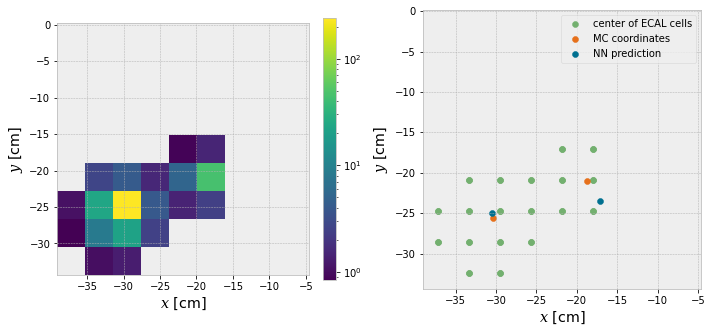

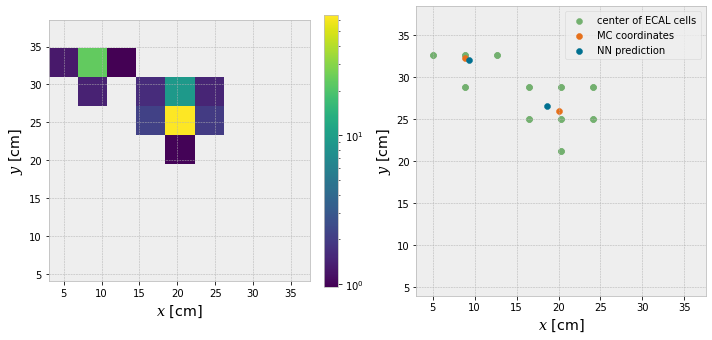

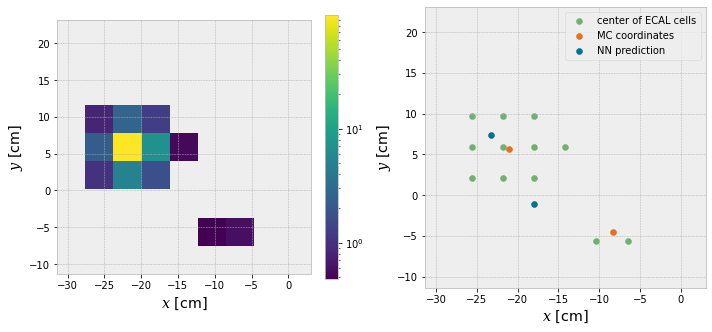

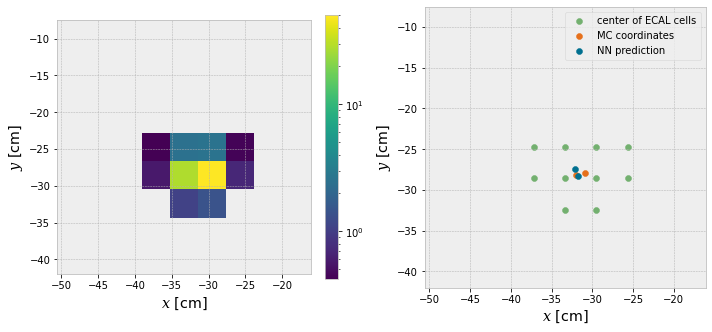

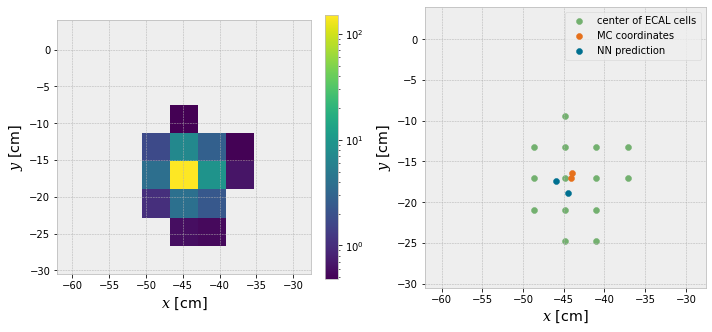

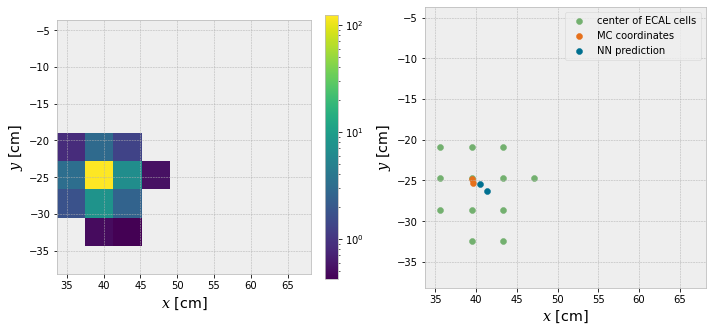

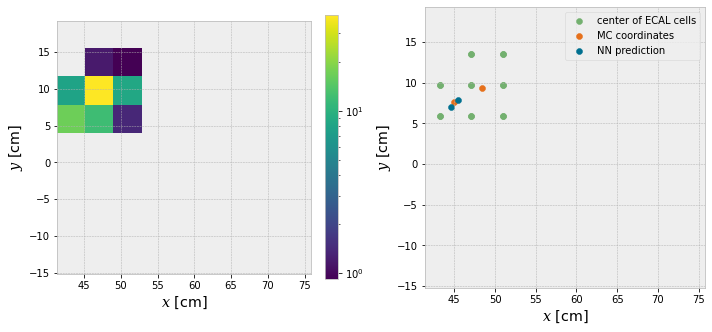

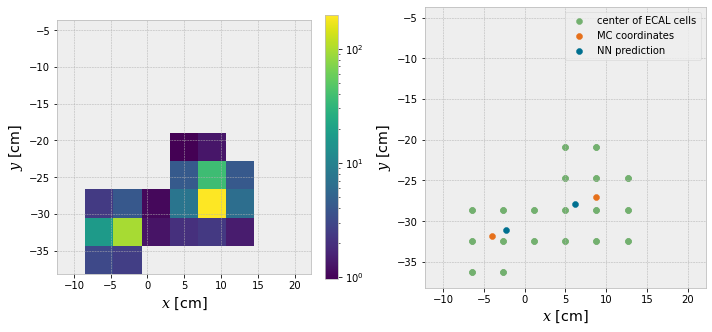

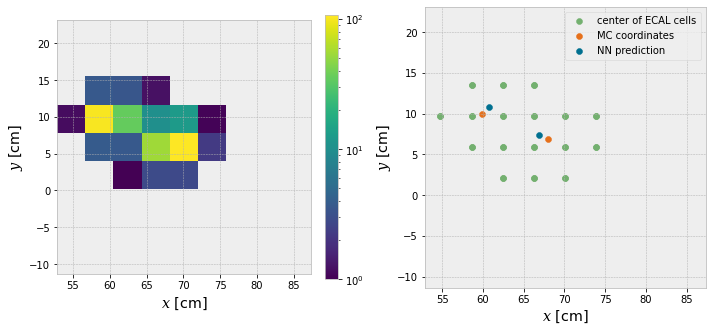

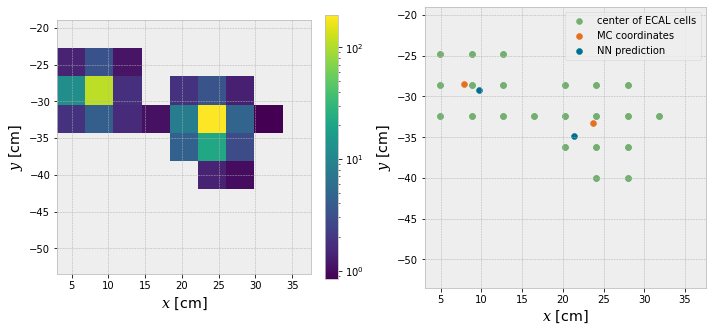

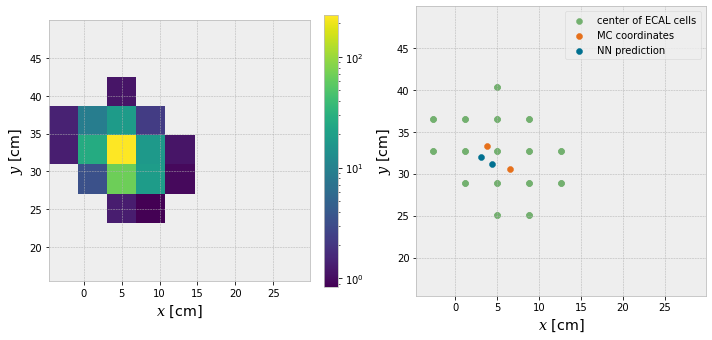

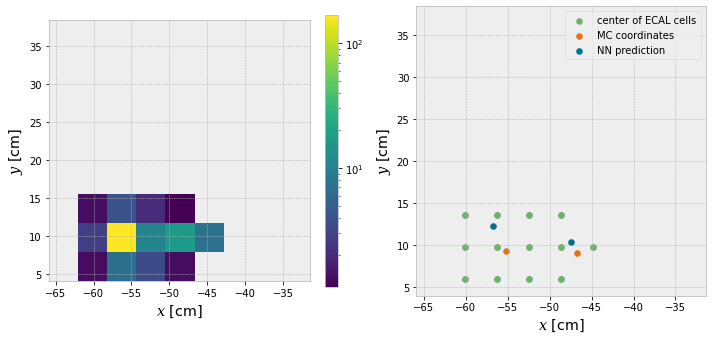

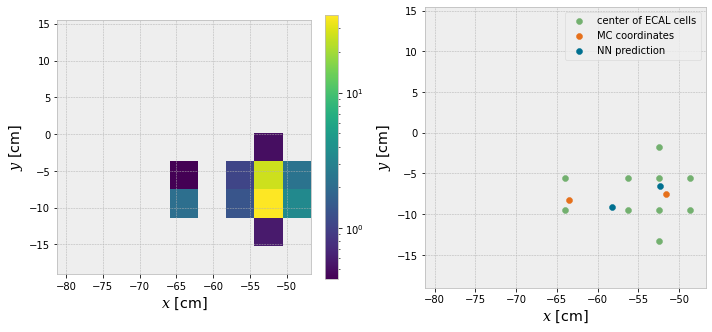

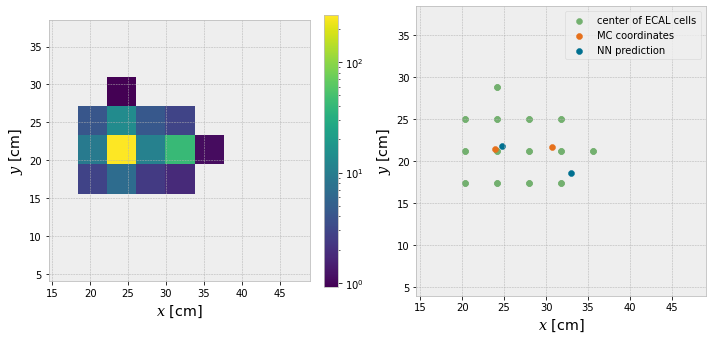

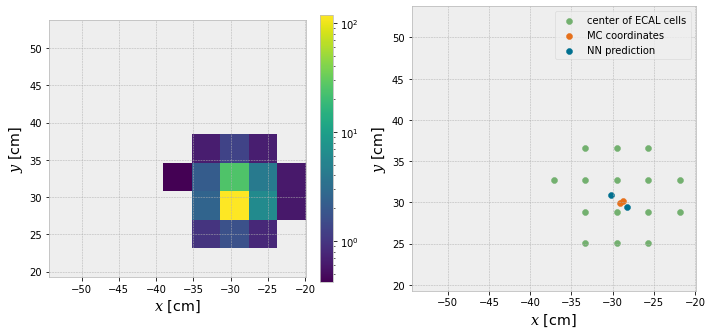

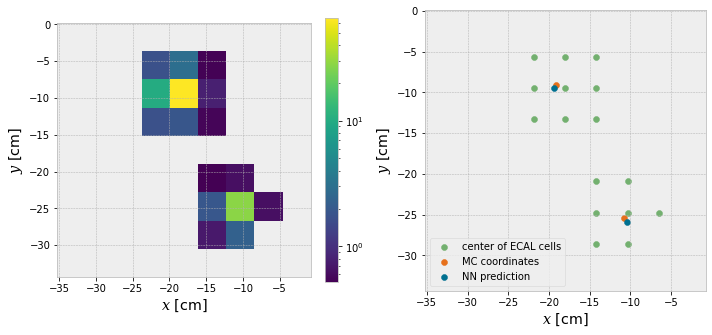

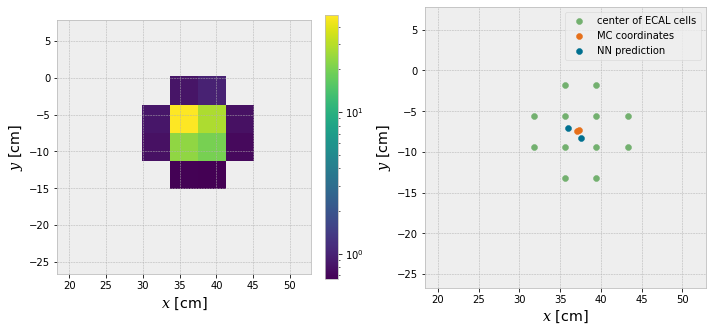

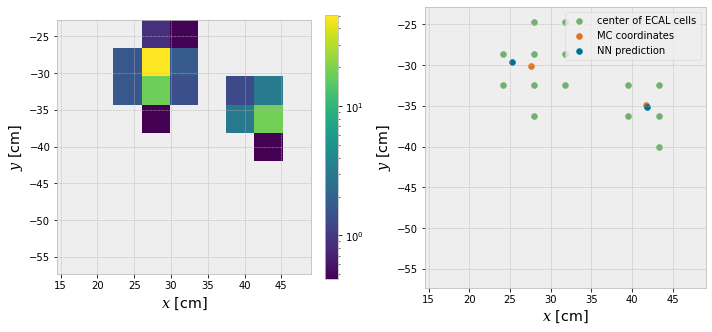

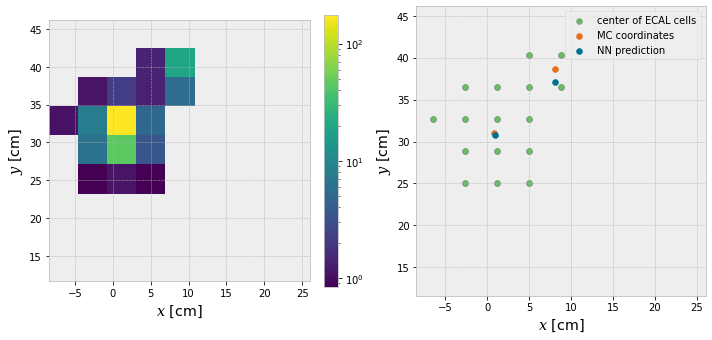

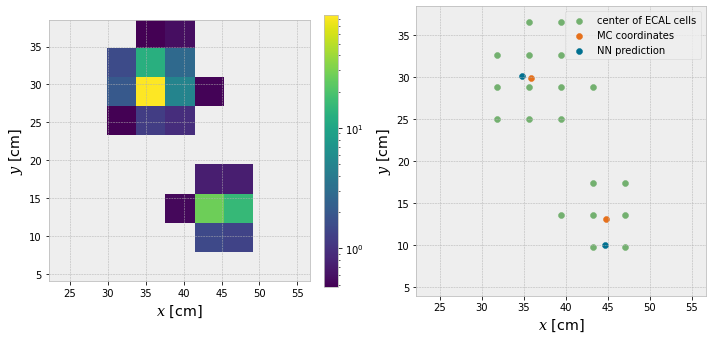

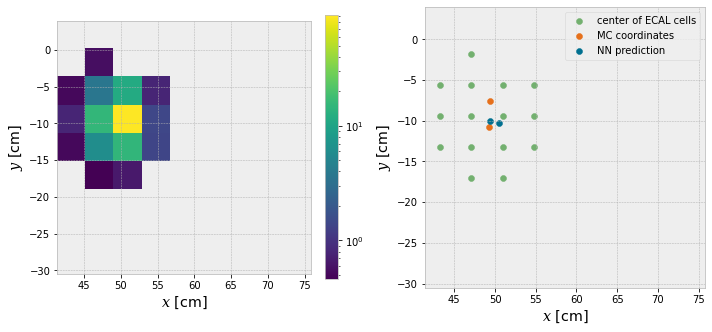

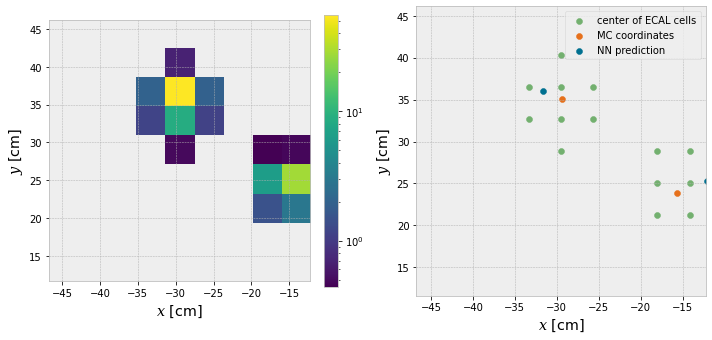

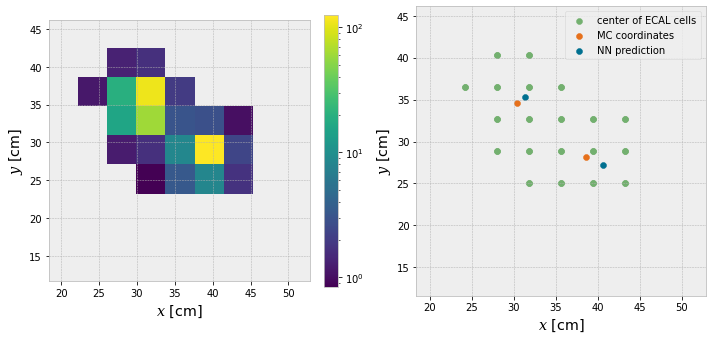

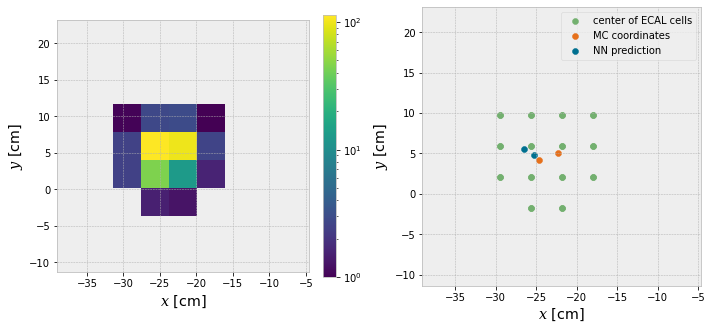

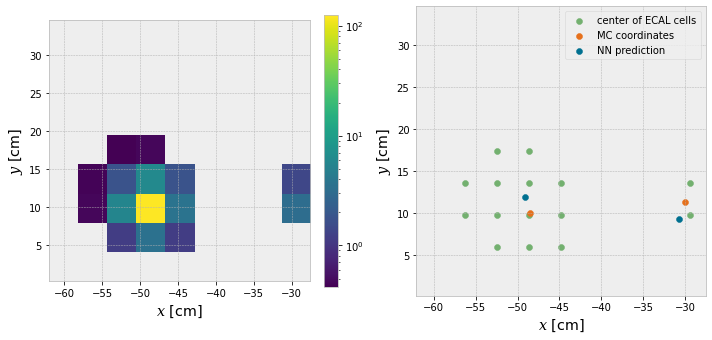

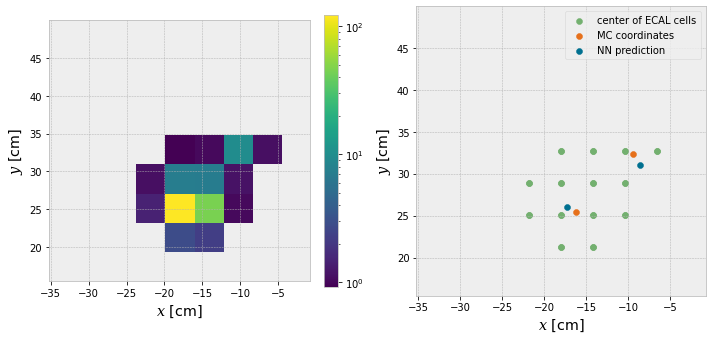

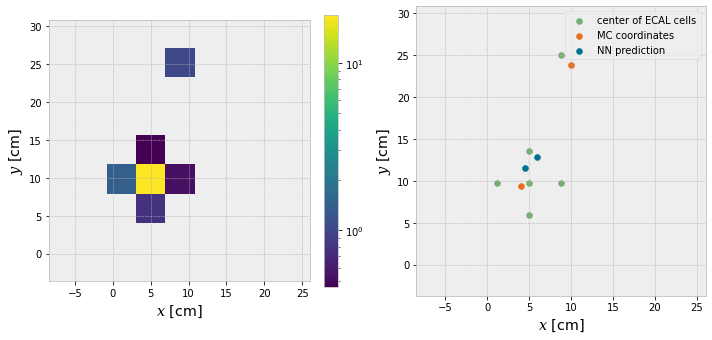

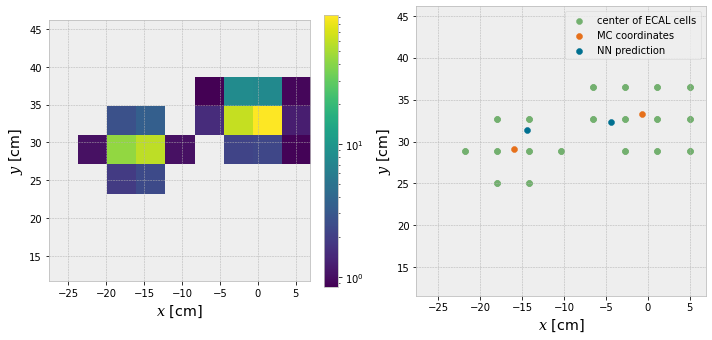

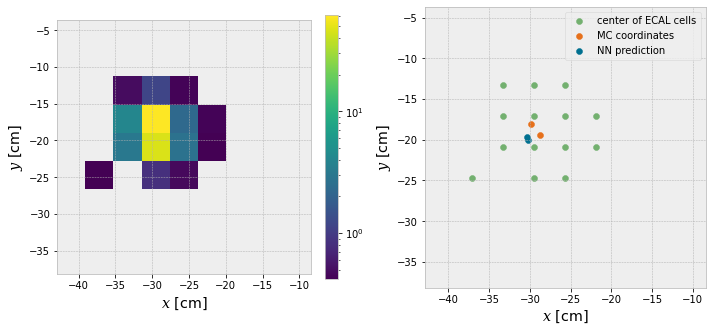

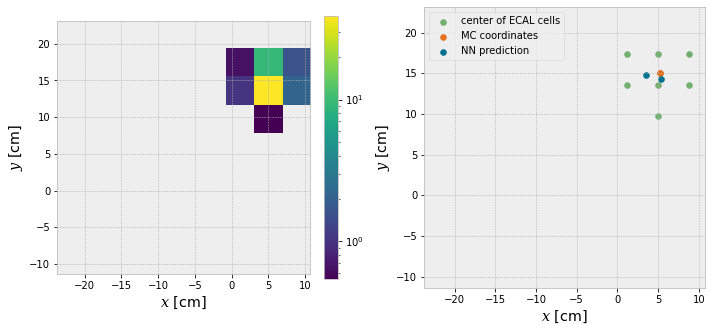

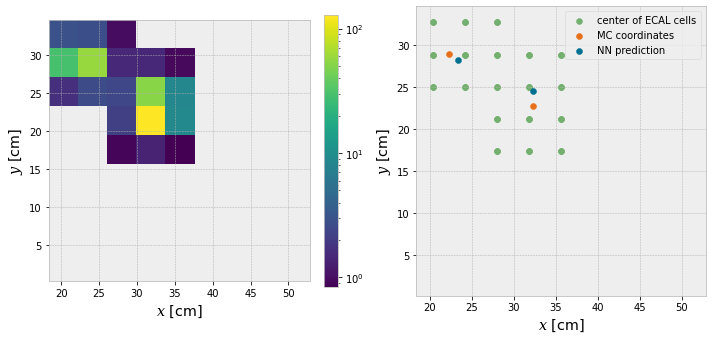

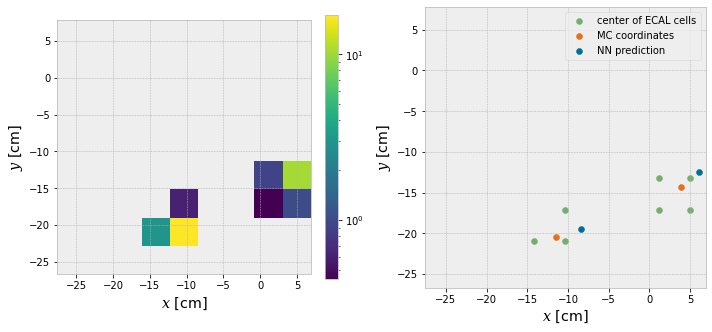

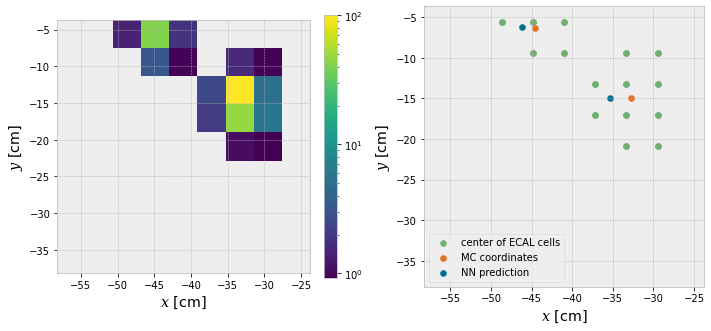

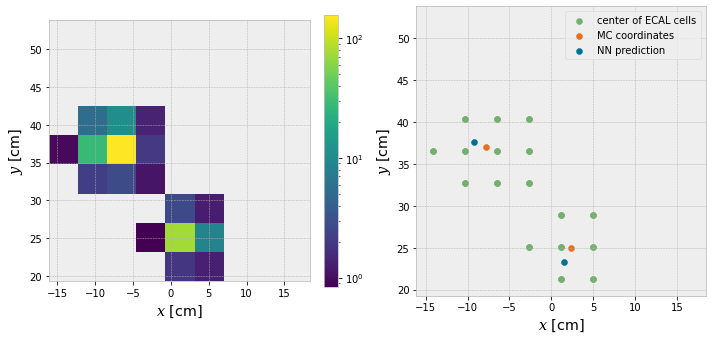

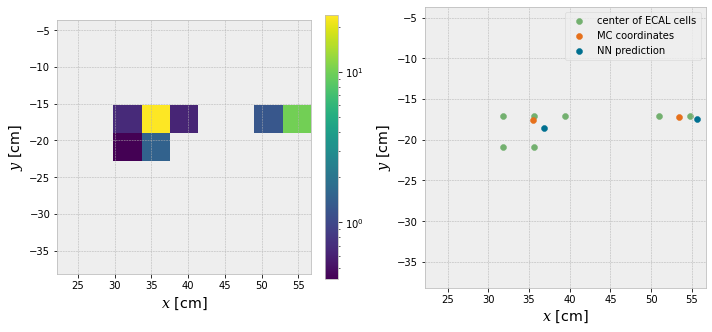

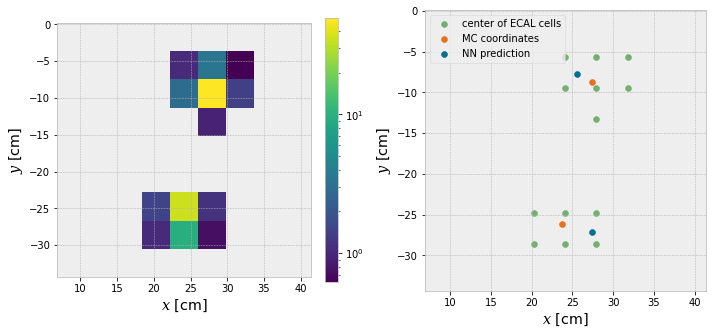

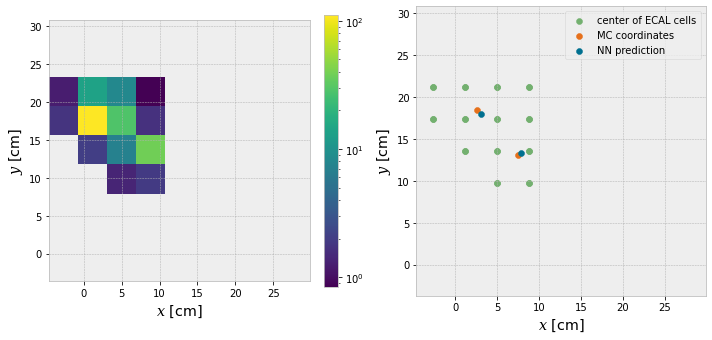

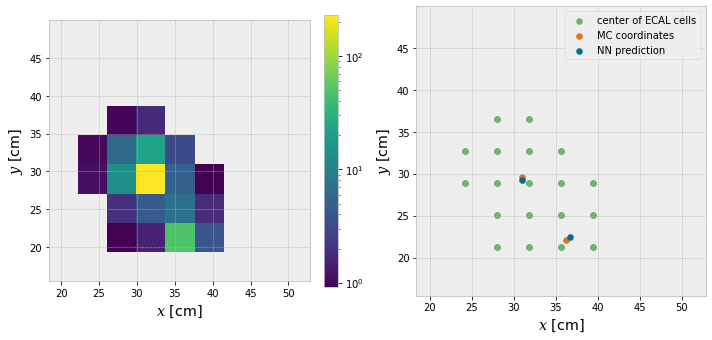

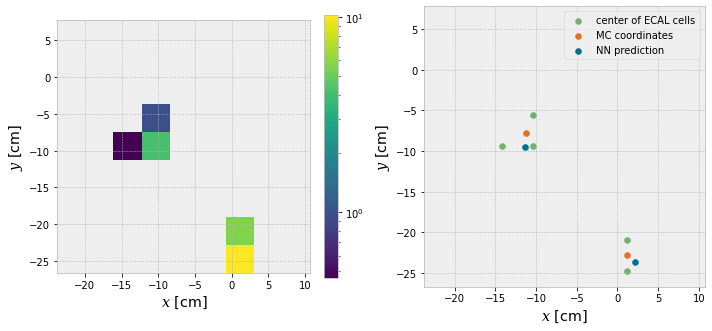

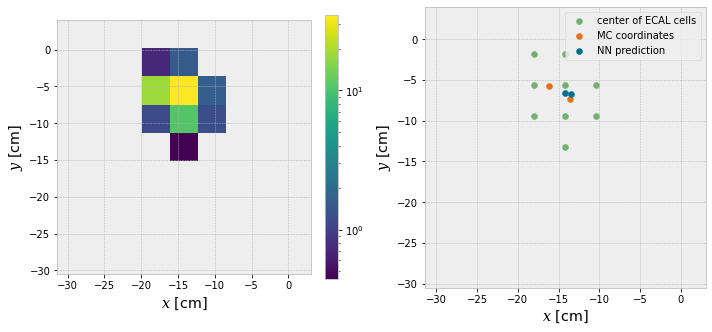

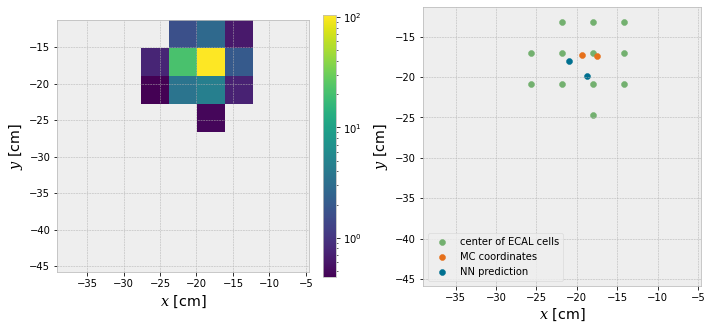

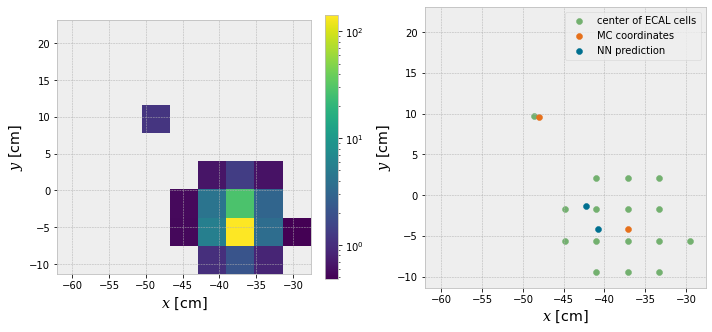

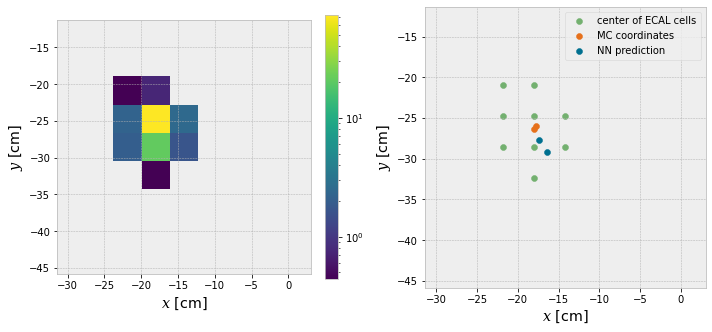

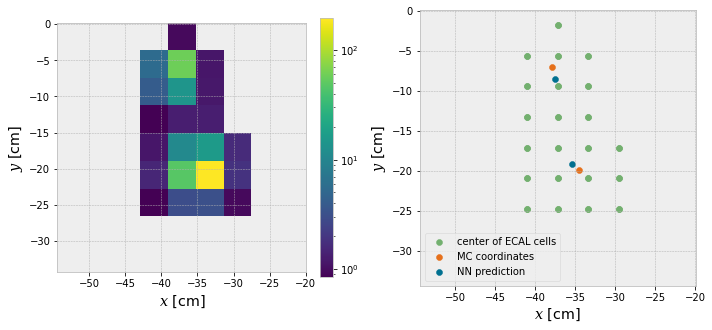

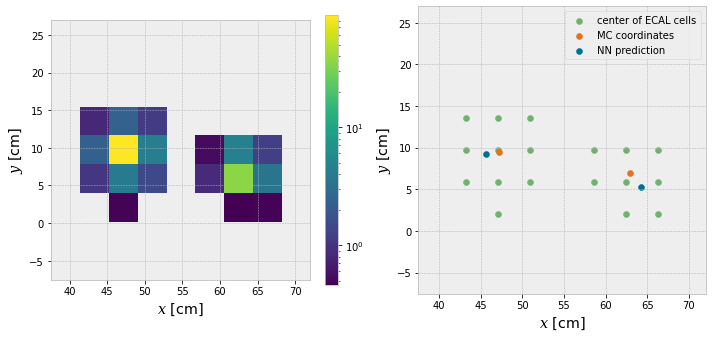

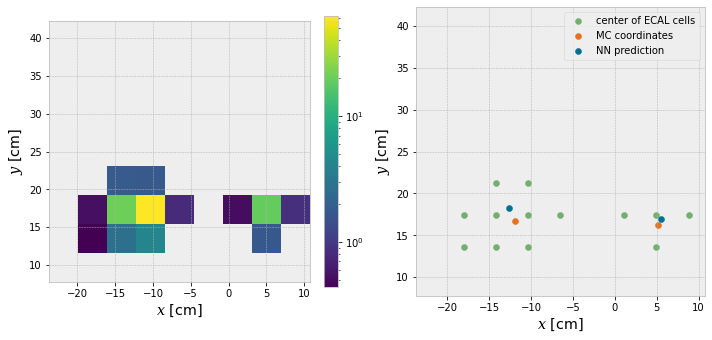

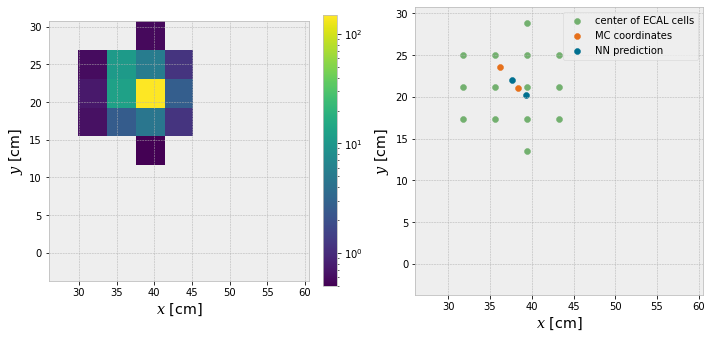

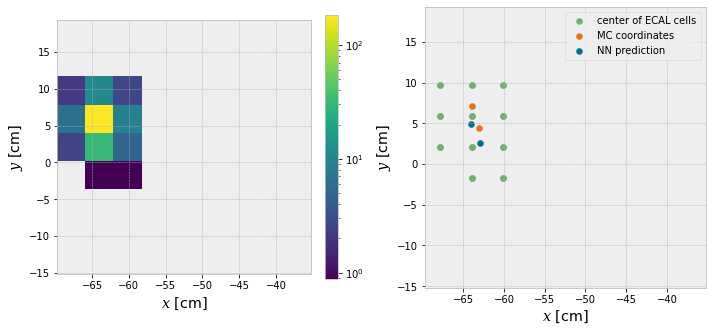

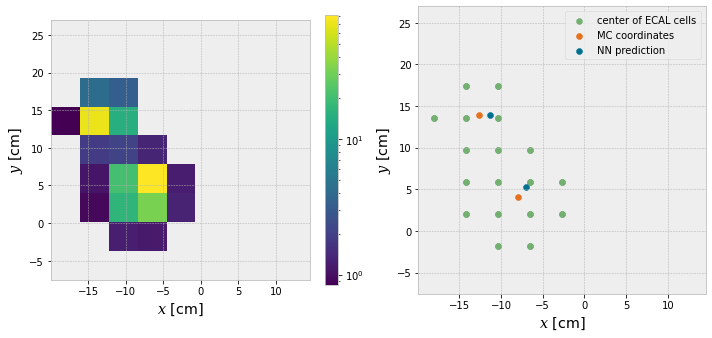

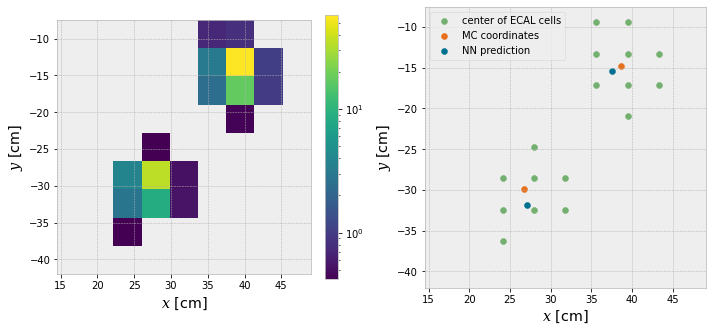

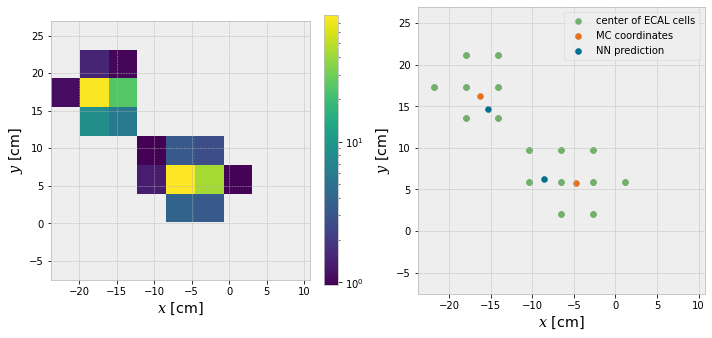

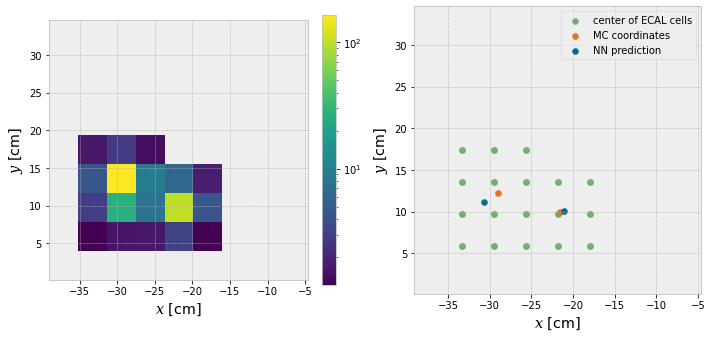

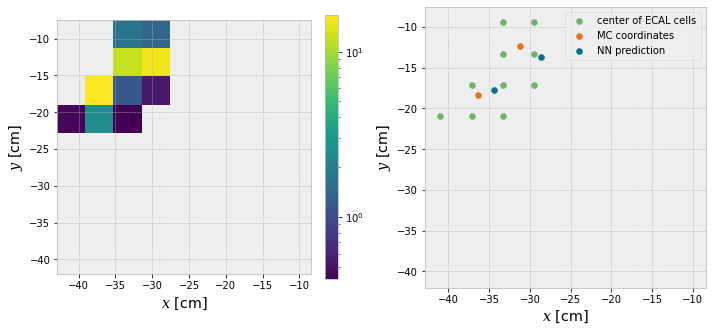

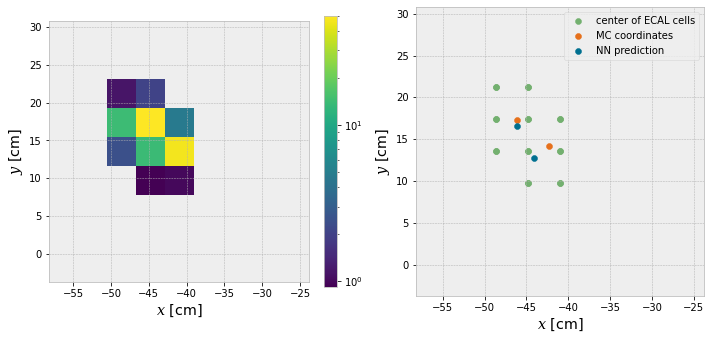

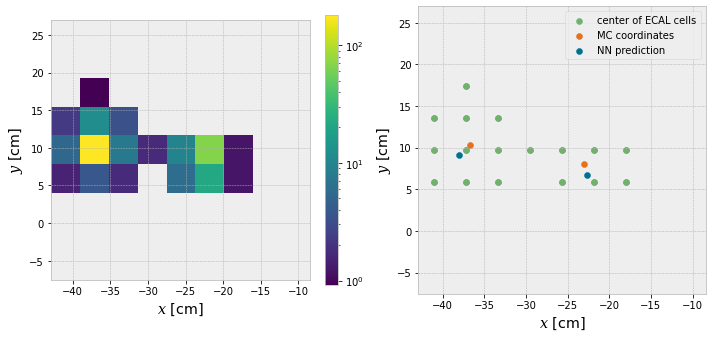

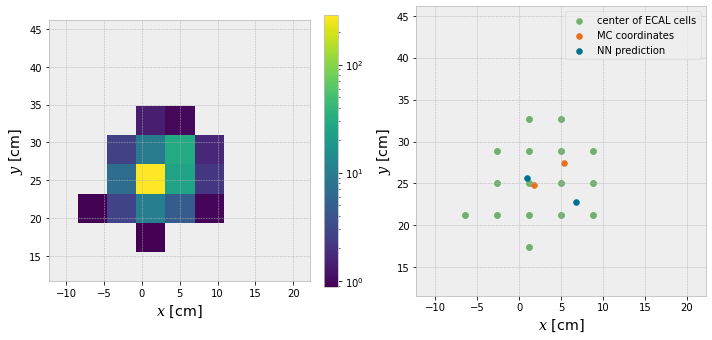

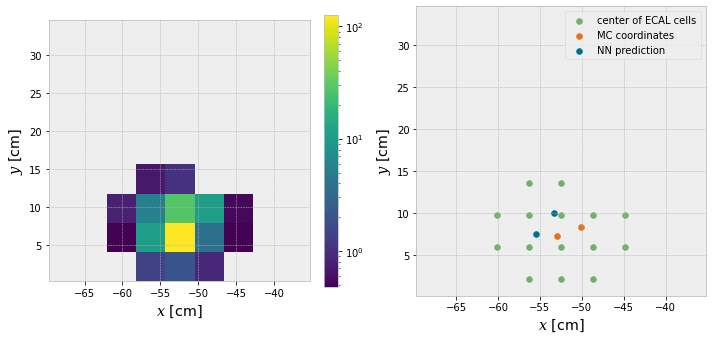

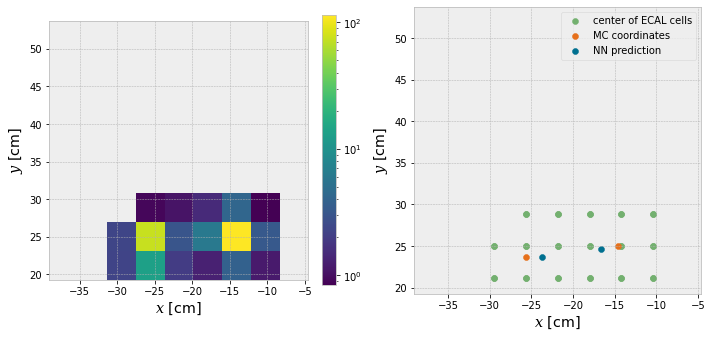

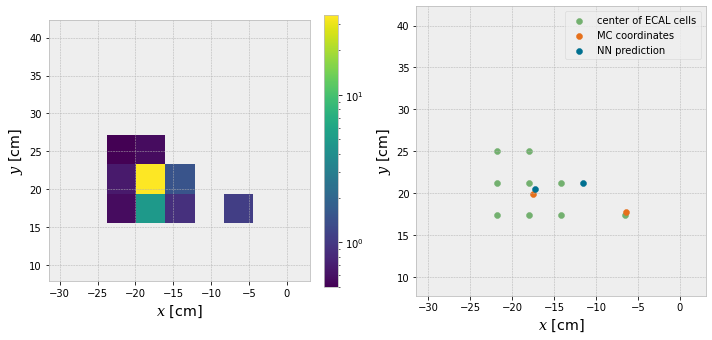

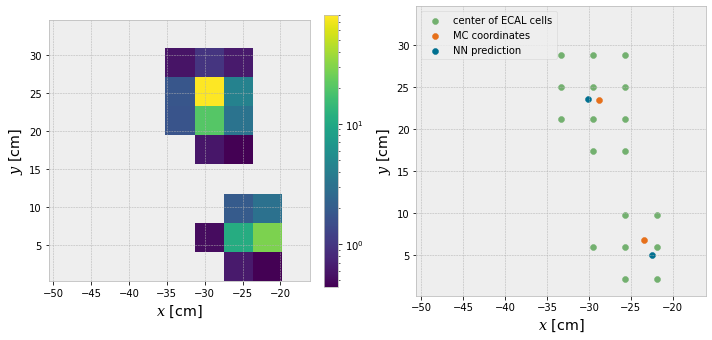

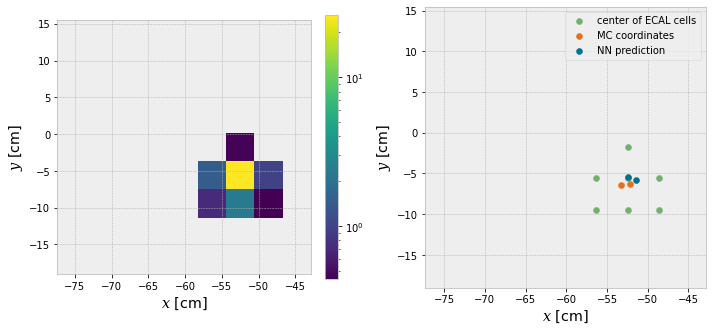

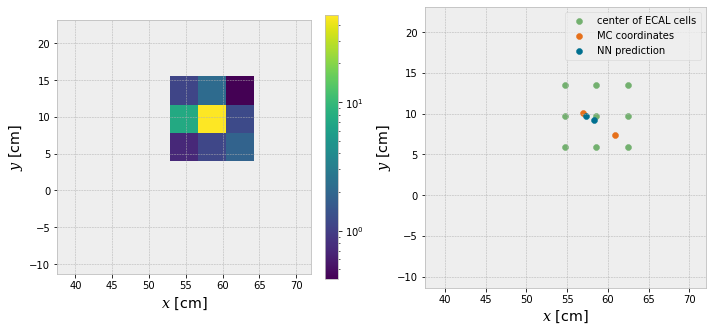

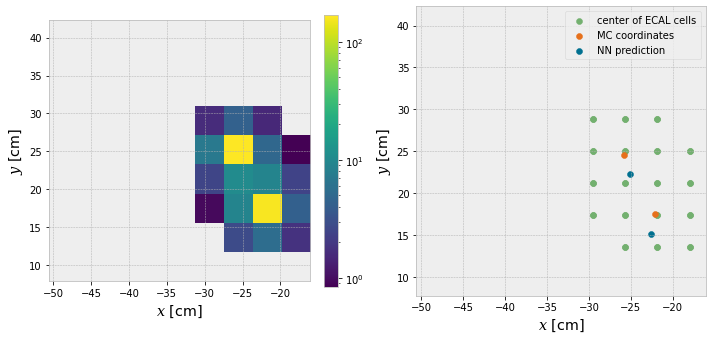

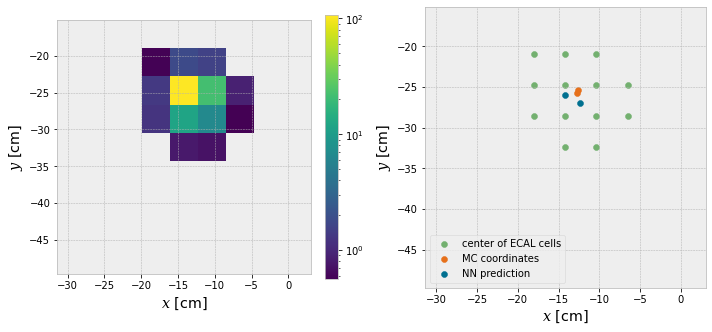

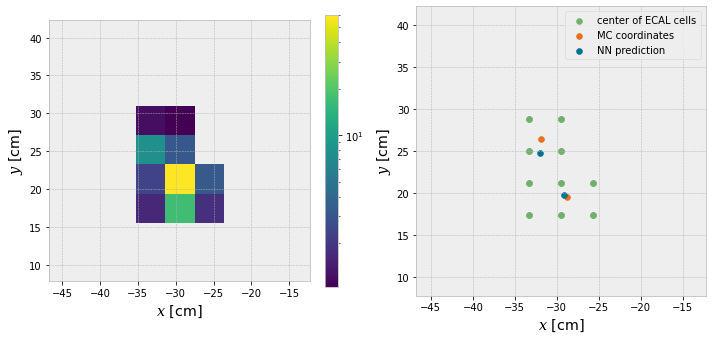

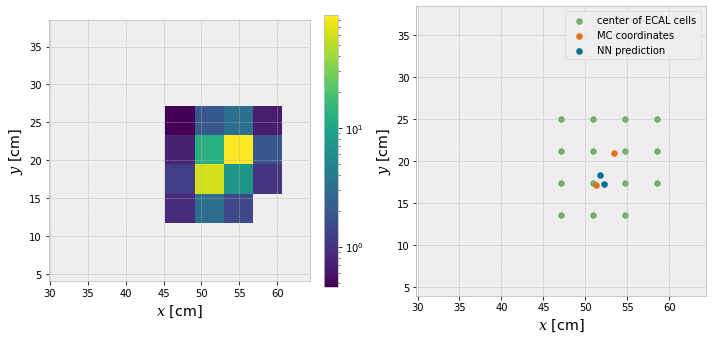

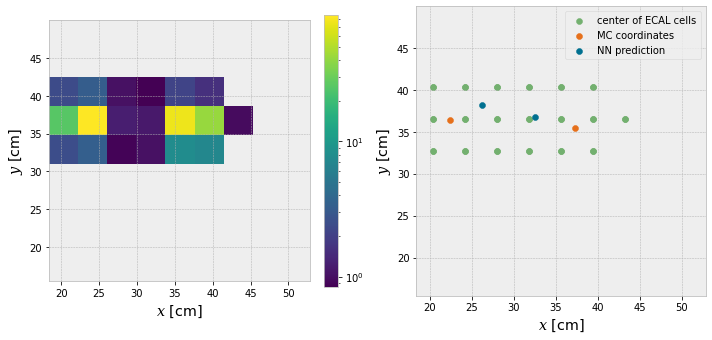

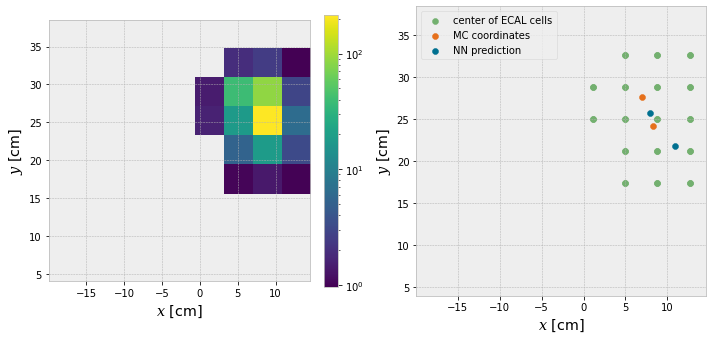

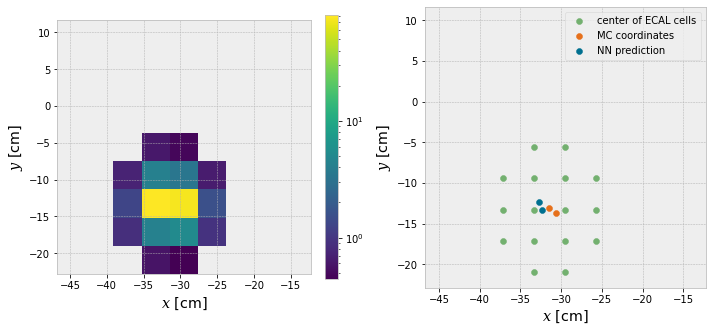

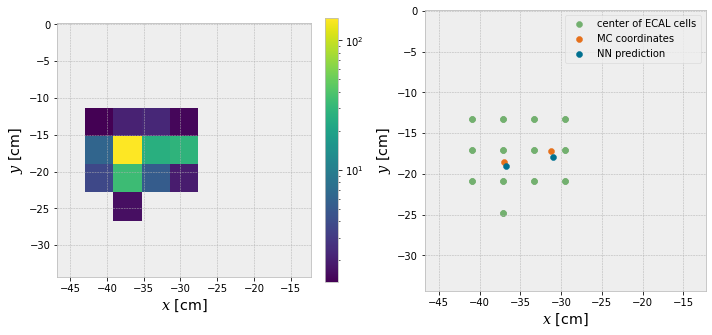

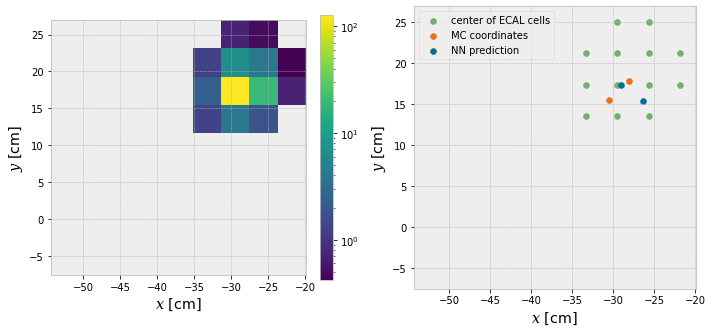

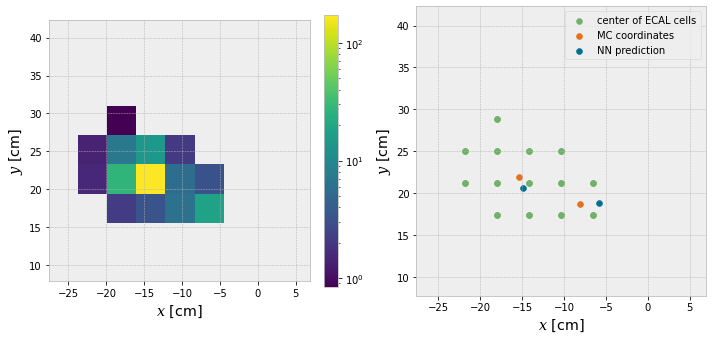

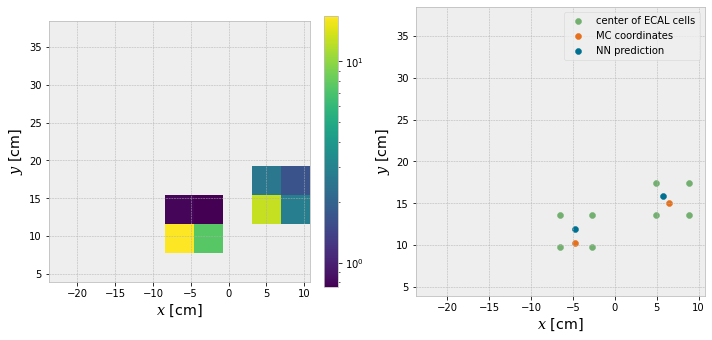

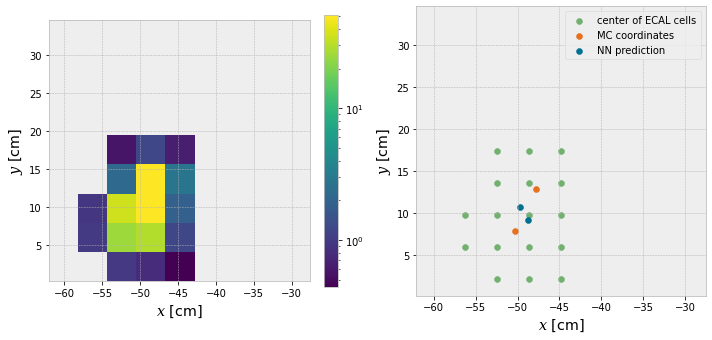

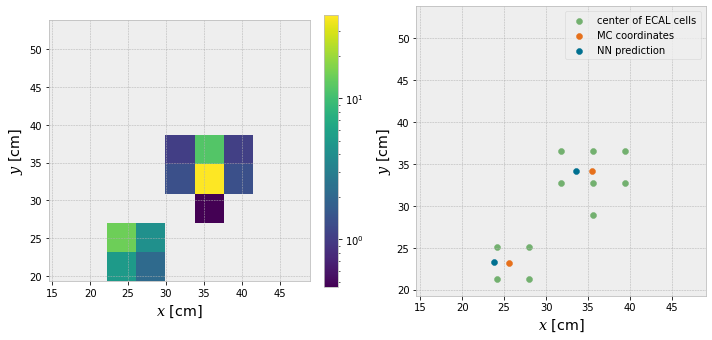

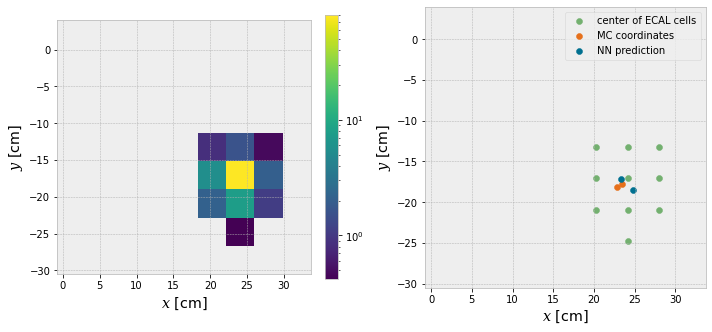

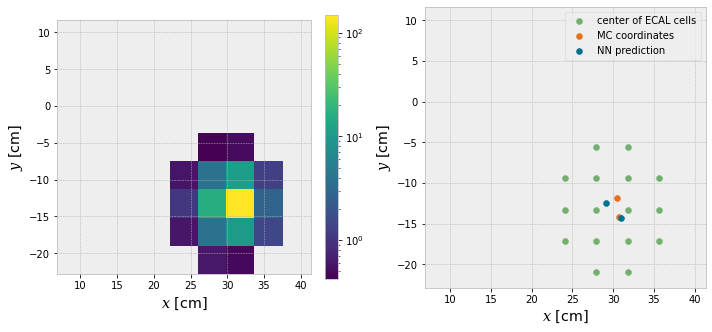

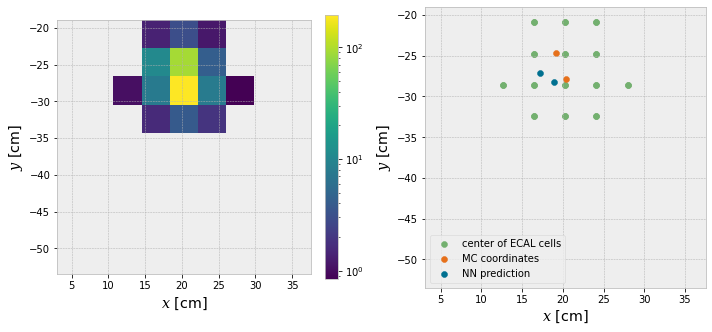

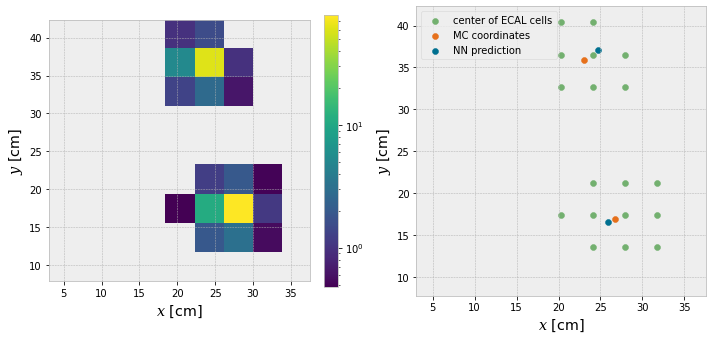

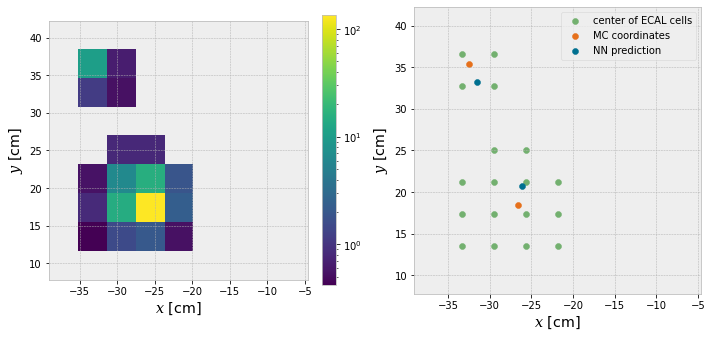

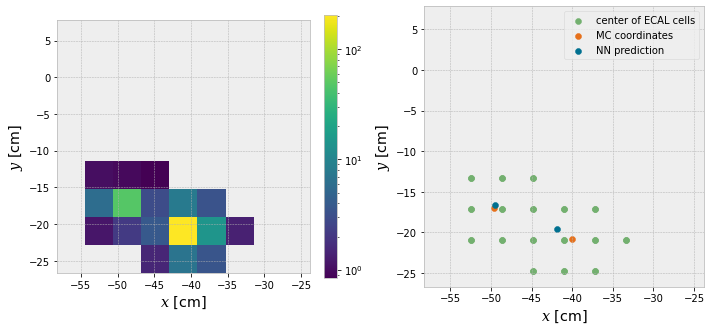

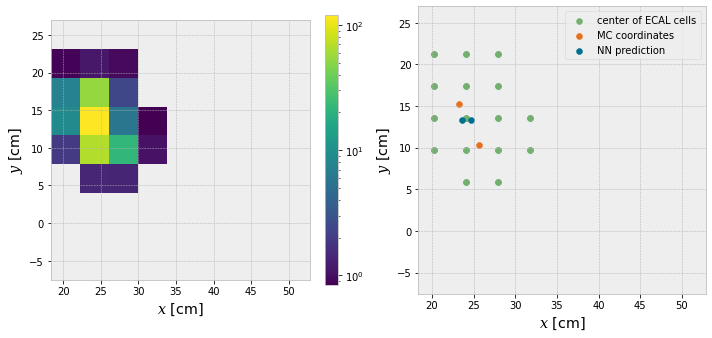

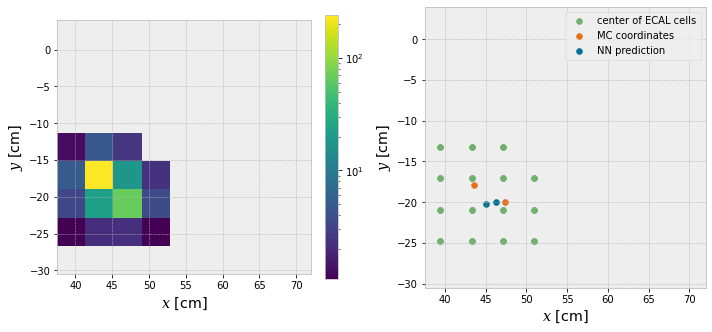

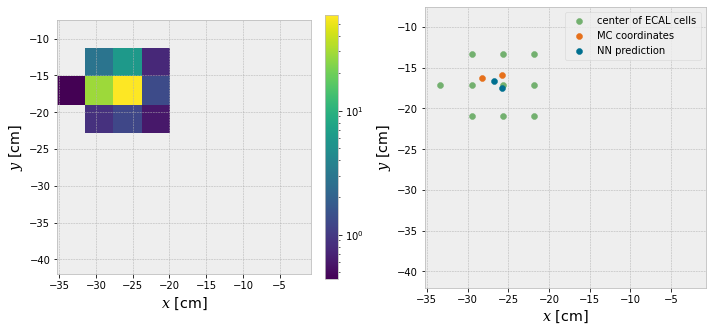

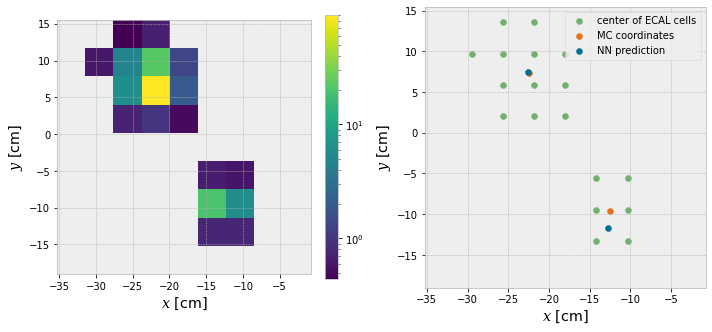

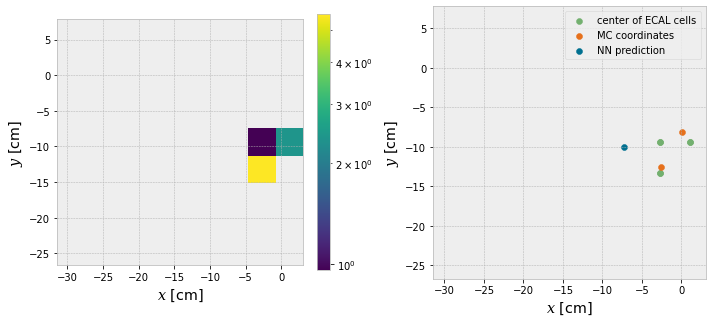

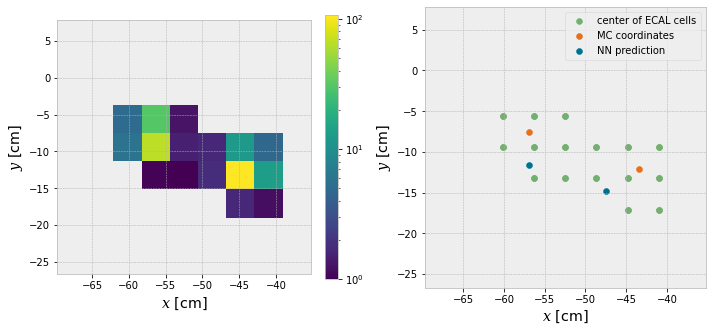

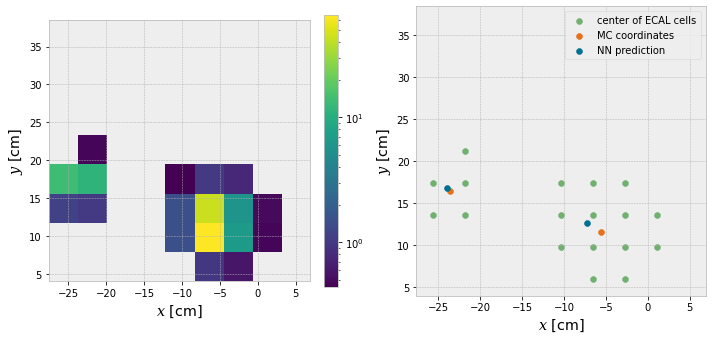

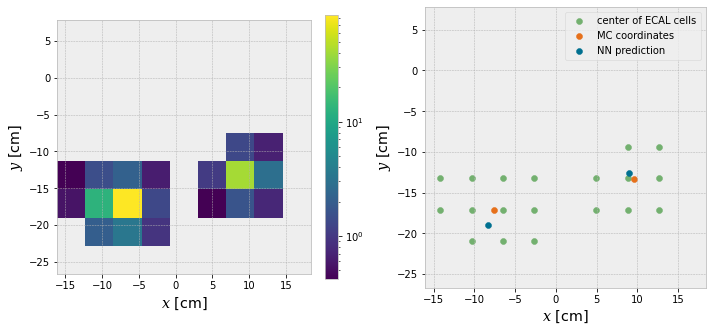

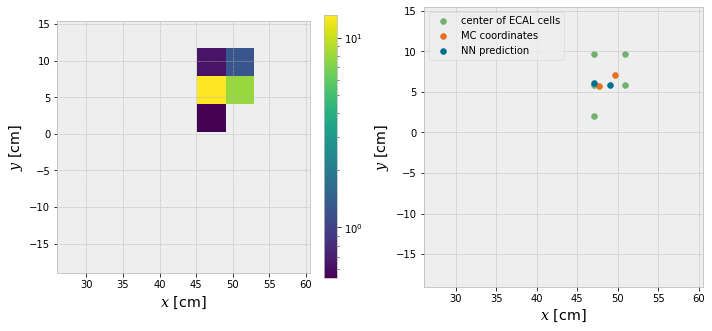

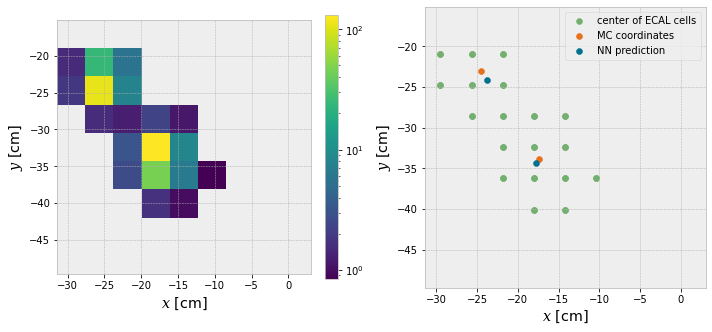

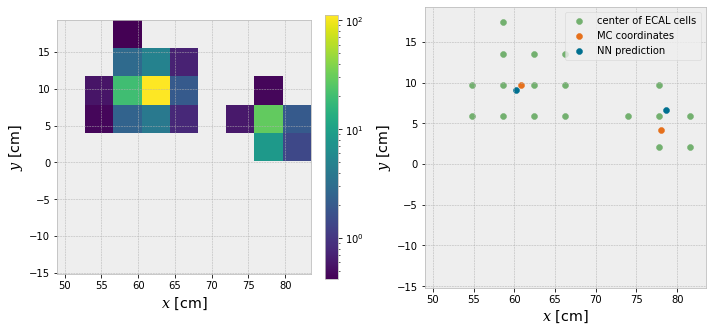

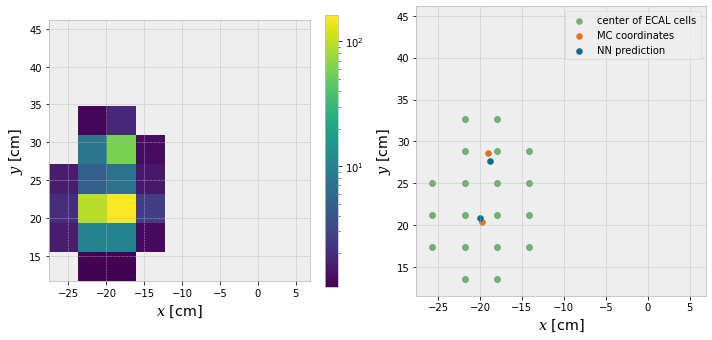

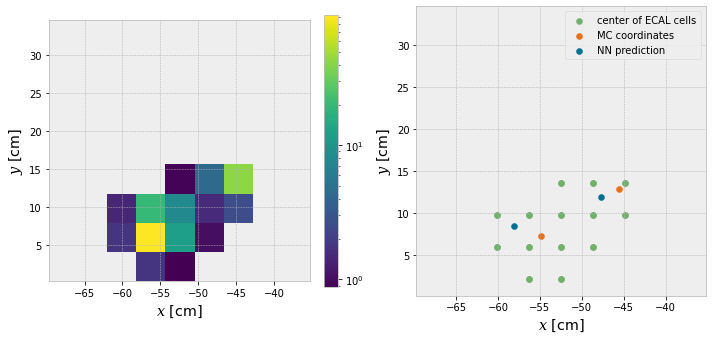

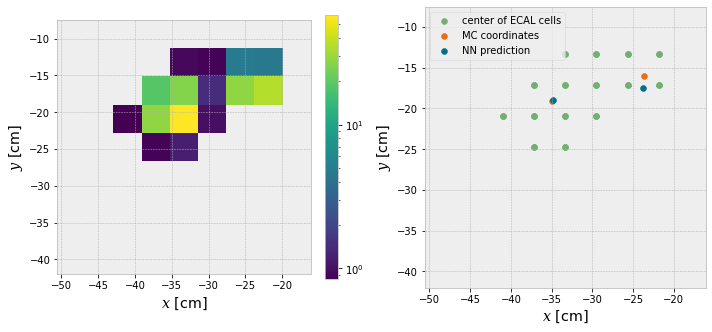

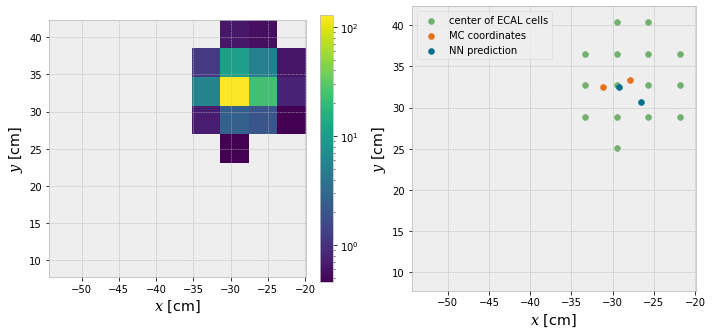

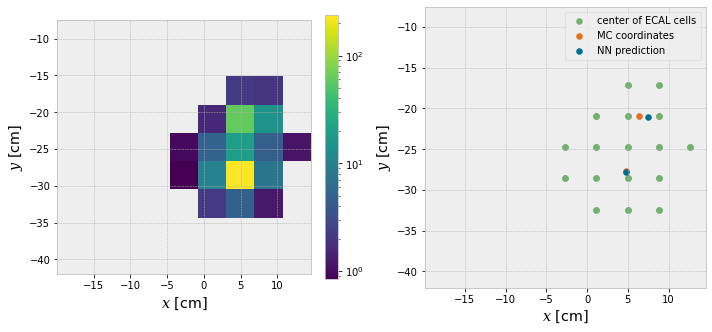

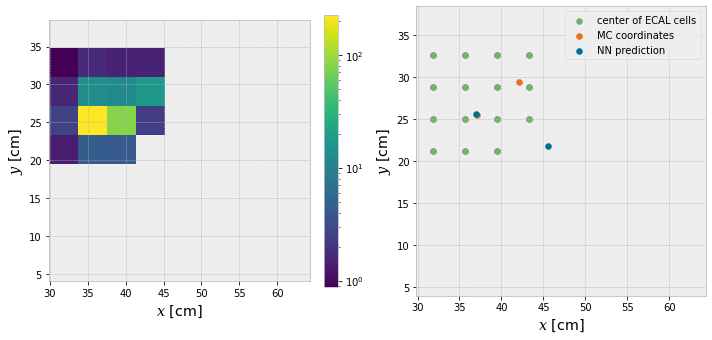

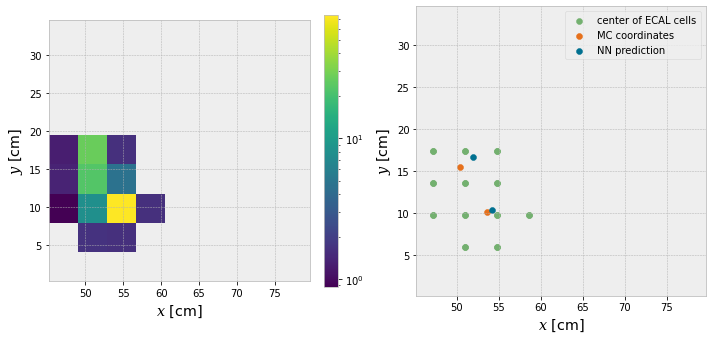

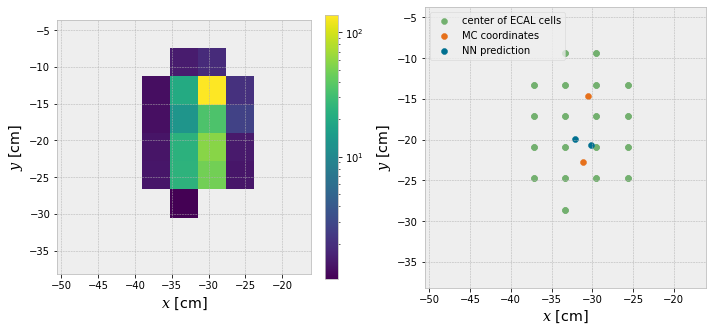

In [17]:
for i in range(100):
    ev.show_cluster_NNpred(i, lednev=False)

Idea: implement drop out?


In [48]:
a = np.arange(20)
ind = np.where(a>10)
print(ind)

(array([11, 12, 13, 14, 15, 16, 17, 18, 19]),)


In [42]:
len(ind[0])

9

In [43]:
int(len(ind[0])*0.2)

1

In [44]:
delete = np.random.choice(len(ind[0]),int(len(ind[0])*0.2), replace=False) # erstes: bis wie hoch, zweites wie viele
print(delete)

[1]


In [45]:
ind_short = np.delete(ind, delete)

In [46]:
print(ind)
print(ind_shortThis article)

(array([11, 12, 13, 14, 15, 16, 17, 18, 19]),)
[11 13 14 15 16 17 18 19]
